In [1]:
import keras
#MATLABで作ったmatファイルを、matフォルダから読み取る
#matファイルは、変数がいくつか保存してあり、それぞれの中身を確認する
#matファイルの中身は、辞書型で保存されている
#辞書型の中身を確認するには、matlab.engineを使う
#matlab.engineを使うには、matlab.engineをインポートする必要がある

# !pip install tensorflow===2.11.0

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


2023-12-18 20:35:27.777651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 20:35:28.294207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7604317762551729407
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14358282240
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4786980343991680143
physical_device_desc: "device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:08:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-12-18 20:35:28.847546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:35:28.869586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:35:28.869793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
#GPUを用いて、tensorflowを使ったseq2seq回帰LSTMモデルを作成する
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.io


In [3]:

#データの読み込み
mat_file = 'mat/60_sin_1period_bpsk_2signal.mat'
data = scipy.io.loadmat(mat_file)

#matファイルの中身の変数名を確認する

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Num_tx', 'R_xx', 'R_xx_after_Noise', 'R_xx_exist_Noise', 'SNR_dB', 'fs', 'inputVec', 'label', 'noise', 's_t', 'sigmaX2', 'stter_vec', 't', 'x'])

In [4]:
a = data['R_xx']
b = data['inputVec']
c = data['label']
d=data['sigmaX2']
e=data['t']
#matに保存した変数の呼び出し
#a,b,cの次元数を確認する
print(a.shape)
print(b.shape)
print(c.shape)

#共分散行列
R=a
#入力信号の電力
sigmax2=d
#スナップショット数
t=e

#実数部と虚数部(虚数単位jは外す)に分ける関数
def split_complex(x):
    real = np.real(x)
    imag = np.imag(x)
    return real, imag

#実数部と虚数部に分ける
real, imag = split_complex(R)


#実数部と虚数部の次元数を確認する
print(real.shape)
print(imag.shape)

#実数部と虚数部を結合し、四次元配列に変換する
R = np.stack([real, imag], axis=3)

#Rの次元数を確認する
print(R.shape)

#Rはx(t)=As(t)+n(t)という信号モデルの共分散行列(Rはx(t)の複素共役転置の期待値)である（Aは方向行列、s(t)は入力信号、n(t)はガウス雑音）
#Rには、本来Aとs(t)とn(t)の情報が含まれているが、今回はn(t)を含まない
#Rにn(t)を乗せる処理を書く
#SNRを定義する
SNR=np.empty((1,1))
np.append(SNR,30)

#送信電力とSNRから雑音電力を求める
#送信電力は、sigmaX2である
#雑音電力は、sigmaN2である
def calculate_noise_covariance(sigmaX2, SNR, t, R):
    # 送信電力から雑音電力を計算する
    sigman2 = np.divide(sigmaX2, (10**(SNR/10)))

    # sigmaN2を表示する
    print(sigman2)

    # ガウス分布に従う雑音n(t)を生成する
    noise = np.sqrt(sigman2/2) * (np.random.randn(len(t),len(R[:,0,0,0])) + 1j*np.random.randn(len(t),len(R[:,0,0,0])))

    # n(t)の次元数を確認する
    print(noise.shape)

    # n(t)の共分散行列を求める
    N = np.dot(np.conj(noise).T, noise)

    # Nの次元数を確認する
    print("R_n", N.shape)

    # Nの実部と虚部を分割する
    real, imag = np.real(N), np.imag(N)

    # Nを結合して次元数を確認する
    N = np.stack([real, imag], axis=2)
    print("R_n", N.shape)

    return N




(10, 10, 1000)
(1000, 101)
(1000, 2)
(10, 10, 1000)
(10, 10, 1000)
(10, 10, 1000, 2)


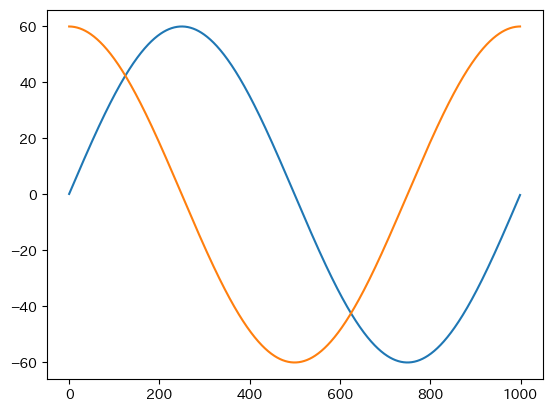

In [5]:
#tensorflowを使ったseq2seq回帰LSTMモデルを作成する

#matファイルで読み込んだinputVecとlabelからデータセットを作成する
#データセットは、inputVecとlabelの組み合わせで、入力と出力を作成する
X = b
Y = c

#Yをプロットする
plt.plot(Y)
plt.show()


In [6]:
#データセットを標準化する
#標準化すると、平均が0、標準偏差が1になる

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# for i in range(X.shape[0]):
#     # シートごとのデータを抽出
#     sheet_data = X[i]
# 
#     # 標準化器を作成し、データを標準化
#     scaler = StandardScaler()
#     sheet_data_standardized = scaler.fit_transform(sheet_data)
# 
#     # 標準化されたデータを元の配列に戻す
#     X[i] = sheet_data_standardized



In [7]:
#データセットの特徴量の値の大部分が同じデータのみの場合にその行（もしくは列）を削除する

from sklearn.feature_selection import VarianceThreshold

# for i in range(X.shape[0]):
#     sheet_data = X[i]  # シートごとのデータを抽出
# 
#     # VarianceThresholdを適用して行（もしくは列）を削除
#     selector = VarianceThreshold()
#     sheet_data_selected = selector.fit_transform(sheet_data)
# 
#     # 削除後のデータを元の配列に戻す
#     if sheet_data_selected.ndim == 1:
#         sheet_data_selected = sheet_data_selected.reshape(-1, 1)
#     X[i] = sheet_data_selected


In [8]:
#Xを3次元配列に変換する
X = np.reshape(X, (X.shape[0], X.shape[1], 1))



In [9]:
from sklearn.model_selection import train_test_split

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
train_size = 0.8
val_size = 0.1
test_size = 0.1

#学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)

#学習データセットと検証データセットとテストデータセットの次元数を確認する
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)

#入力の次元はそれぞれ(サンプル数、タイムステップ数、特徴量)である
#Xの2番目の次元と3番目の次元を入れ替える
XTrain = np.swapaxes(XTrain, 1, 2)
XVal = np.swapaxes(XVal, 1, 2)
XTest = np.swapaxes(XTest, 1, 2)


(800, 101, 1)
(100, 101, 1)
(100, 101, 1)
(800, 2)
(100, 2)
(100, 2)


In [10]:
#GPUを使ったLSTMmodelの作成

#tensorflowのバージョンを確認する
print(tf.__version__)


2.12.1


In [11]:

##from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# from keras.layers.normalization import batch_normalization
# from tensorflow.python.keras.layers import
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

#モデルの層の作成(cudNNLSTM層を使用するためのインポート)
from tensorflow.keras.layers import LSTM

print((XTrain.shape[1:]))

hidden_units = 256

#モデルの作成
model = keras.Sequential()
model.add(LSTM(hidden_units, input_shape=(XTrain.shape[1:]), return_sequences=True))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(LSTM(hidden_units, return_sequences=True))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

# LearningRateSchedulerコールバックを作成する
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

opt = Adam(learning_rate=0.01)

# コンパイル時にオプティマイザを指定する(損失関数はMSE、評価関数はRMSEをカスタムで実装)

loss_func = tf.keras.losses.MeanSquaredError(
    reduction='auto', name='mean_squared_error'
)

eval_func = tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

model.compile(loss=loss_func, optimizer=opt, metrics=eval_func)

#モデルの概要を表示する
model.summary()


(1, 101)


2023-12-18 20:35:29.877607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:35:29.877833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 20:35:29.878022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            366592    
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            525312    
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 dense (Dense)               (None, 1, 1)              257       
                                                                 
Total params: 892,161
Trainable params: 892,161
Non-trainable params: 0
_________________________________________________________________


2023-12-18 20:35:30.428461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 20:35:30.429143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 20:35:30.429798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
# TensorBoardコールバックを作成
tensorboard = TensorBoard(log_dir='./logs')
#plotをlocalhostで表示

#ターミナルにコマンドを打つ
# tensorboard --logdir logs


In [13]:

#モデルの学習

#モデルの学習の早期終了の設定
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
max_epochs = 100
mini_batch_size = 32

#モデルの学習
history = model.fit(XTrain, YTrain, batch_size=mini_batch_size, epochs=max_epochs, validation_data=(XVal, YVal),
                    callbacks=[reduce_lr, tensorboard])


Epoch 1/100


2023-12-18 20:35:30.624038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 20:35:30.624933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 20:35:30.625573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

23/25 [==========================>...] - ETA: 0s - loss: 1416.9011 - root_mean_squared_error: 37.6417 

2023-12-18 20:35:32.291055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 20:35:32.291908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 20:35:32.292469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 2s 18ms/step - loss: 1412.0150 - root_mean_squared_error: 37.5768 - val_loss: 1799.8409 - val_root_mean_squared_error: 42.4245 - lr: 0.0100
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 1318.0441 - root_mean_squared_error: 36.3049 - val_loss: 1799.8086 - val_root_mean_squared_error: 42.4242 - lr: 0.0100
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 1315.0162 - root_mean_squared_error: 36.2632 - val_loss: 1799.7588 - val_root_mean_squared_error: 42.4236 - lr: 0.0100
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 1311.8855 - root_mean_squared_error: 36.2200 - val_loss: 1799.7013 - val_root_mean_squared_error: 42.4229 - lr: 0.0100
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 1299.8107 - root_mean_squared_error: 36.0529 - val_loss: 1799.8936 - val_root_mean_squared_error: 42.4252 - lr: 0.0100
Epoch 6/100
25/25 [==============================] 

In [14]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])


4/4 [==============================] - 0s 2ms/step - loss: 1394.9259 - root_mean_squared_error: 37.3487
Test loss: 1394.9259033203125
Test accuracy: 37.34870529174805


In [15]:
#モデルの保存

#モデルの保存
model.save('model/LSTMmodel.h5')


In [16]:
#モデルの読み込み

#モデルの読み込み
model = tf.keras.models.load_model('model/LSTMmodel.h5')

#モデルの概要を表示する
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            366592    
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            525312    
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 dense (Dense)               (None, 1, 1)              257       
                                                                 
Total params: 892,161
Trainable params: 892,161
Non-trainable params: 0
_________________________________________________________________


2023-12-18 20:35:42.480191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 20:35:42.481075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 20:35:42.481664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [17]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])



2023-12-18 20:35:42.764502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 20:35:42.765233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 20:35:42.765934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 3ms/step - loss: 1394.9259 - root_mean_squared_error: 37.3487
Test loss: 1394.9259033203125
Test accuracy: 37.34870529174805


In [18]:
#モデルの予測

#モデルの予測

#予測値を格納する変数を作成する
YTestPred = np.zeros((YTest.shape[0], 1))

#予測値を計算する
YTestPred = model.predict(XTest)

#予測値を表示する
print(YTestPred[:, 0, :])


4/4 [==============================] - 0s 1ms/step


2023-12-18 20:35:43.135660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 20:35:43.136514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 20:35:43.137103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

[[ 6.5902824]
 [ 6.96877  ]
 [ 7.3512497]
 [ 7.4735727]
 [ 8.217612 ]
 [ 7.8567553]
 [ 8.247671 ]
 [ 8.734245 ]
 [ 8.820328 ]
 [ 8.903915 ]
 [ 9.198927 ]
 [ 9.698424 ]
 [ 9.723375 ]
 [ 9.888664 ]
 [10.394124 ]
 [10.46233  ]
 [10.901696 ]
 [11.171553 ]
 [11.569845 ]
 [11.847681 ]
 [12.010544 ]
 [12.270283 ]
 [12.621513 ]
 [12.899381 ]
 [13.006053 ]
 [13.381737 ]
 [13.647753 ]
 [13.860661 ]
 [14.1988125]
 [14.393266 ]
 [14.420527 ]
 [14.661196 ]
 [15.106971 ]
 [15.334311 ]
 [15.513995 ]
 [15.641348 ]
 [15.980678 ]
 [16.286552 ]
 [16.484978 ]
 [16.865627 ]
 [17.064062 ]
 [17.338627 ]
 [17.591457 ]
 [17.769892 ]
 [18.132341 ]
 [18.34341  ]
 [18.542538 ]
 [18.951248 ]
 [18.991734 ]
 [19.236572 ]
 [19.45406  ]
 [19.780293 ]
 [20.0246   ]
 [20.142113 ]
 [20.281494 ]
 [20.636074 ]
 [20.685823 ]
 [20.91446  ]
 [21.19381  ]
 [21.333107 ]
 [21.699043 ]
 [22.157671 ]
 [22.258581 ]
 [22.418106 ]
 [22.719511 ]
 [22.842407 ]
 [23.04018  ]
 [23.250381 ]
 [23.448915 ]
 [23.673443 ]
 [23.796951 ]
 [24.0

(100,)
(100, 2)


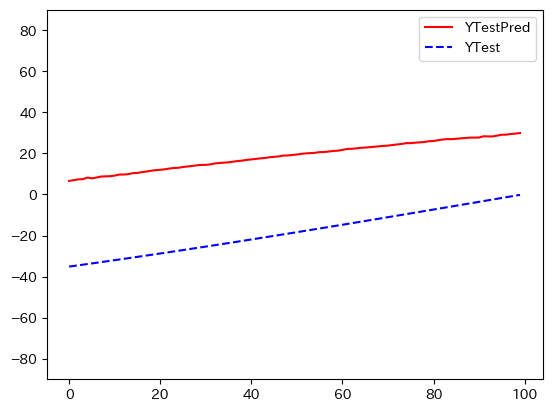

In [19]:
#予測値と正解値のグラフを表示する
print(YTestPred[:, 0, 0].shape)
print(YTest.shape)

#予測値と正解値を一つのグラフに表示する
plt.plot(YTestPred[:, 0, 0], label='YTestPred', color='red')
plt.plot(YTest[:, 0], label='YTest', linestyle='dashed', color='blue')
plt.ylim(-90, 90)
plt.legend()
plt.show()


(100,)


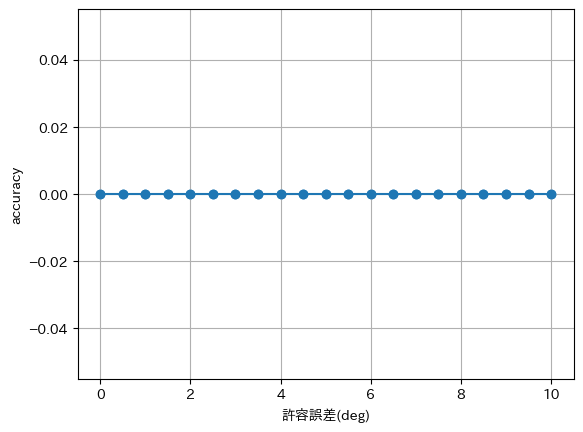

In [20]:
#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値のグラフを表示する

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を計算する
YTestDiff = ((YTestPred[:, 0, 0] - YTest[:, 0]))

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を表示する
print(YTestDiff.shape)

thr = np.arange(0, 10.5, 0.5)
numCorrect = np.zeros(len(thr))
numValidationImages = np.zeros(len(thr))
accuracy = np.zeros(len(thr))

for i in range(len(thr)):
    numCorrect[i] = np.sum(np.abs(YTestDiff) < thr[i])
    numValidationImages[i] = np.size(YTest[:, 0])
    accuracy[i] = numCorrect[i] / numValidationImages[i]

plt.scatter(thr, accuracy)
plt.xlabel("許容誤差(deg)")
plt.ylabel("accuracy")
plt.grid(True)
plt.plot(thr, accuracy, '.-', markersize=12)
plt.show()

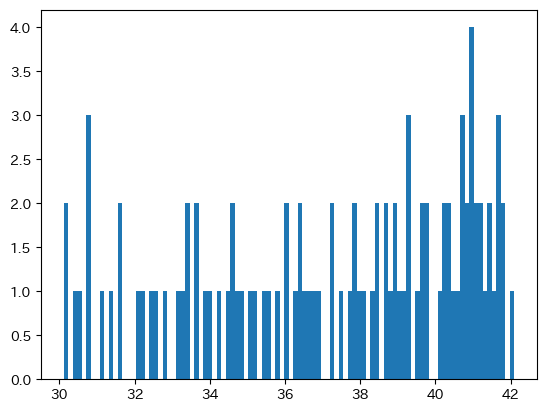

In [21]:
#予測値と正解値の差分のヒストグラムを表示する

#予測値と正解値の差分のヒストグラムを表示する
plt.hist(YTestDiff, bins=100)
plt.show()


In [22]:
#予測値と正解値の差分の統計量を表示する

#予測値と正解値の差分の統計量を表示する
print(pd.DataFrame(YTestDiff).describe())


                0
count  100.000000
mean    37.183640
std      3.562269
min     30.109104
25%     34.465901
50%     37.887140
75%     40.424084
max     42.099127


In [23]:
#